# Import

In [1]:
import torch
import os
from matplotlib import pyplot as plt

from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from utils.visualization_helpers import load_noisy_and_target_image, show_images
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration

# Configuration

In [2]:
fit_model_configuration = get_fit_model_configuration()

fit_model_configuration.noisy_image_path = 'data/raw_images/cameraman_noisy.png'
fit_model_configuration.target_image_path = 'data/raw_images/cameraman_target.png'

fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [6, 6]
fit_model_configuration.number_of_hidden_channels = 64
fit_model_configuration.number_of_layers = 6

fit_model_configuration.log_frequency = 1
fit_model_configuration.convergence_check_length = 2000

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(str(fit_model_configuration))

number of GPUs:  1
noisy_image_path: data/raw_images/cameraman_noisy.png  
target_image_path: data/raw_images/cameraman_target.png  
result_path: data/results/  
image_shape: (256, 256, 3)  
model_type: deep  
input_shape: [6, 6]  
number_of_layers: 6  
number_of_hidden_channels: 64  
number_of_iterations: 30000  
learning_rate: 0.1  
convergence_check_length: 2000  
log_frequency: 1  
find_best: True  
data_type: <class 'torch.cuda.FloatTensor'>  



# Fitting

In [3]:
noisy_image, target_image = load_noisy_and_target_image(fit_model_configuration)
model = create_model_from_configuration(fit_model_configuration)
fitter = create_fitter_from_configuration(fit_model_configuration)
fitter(model, noisy_image, target_image)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Step: 06286, Loss: 0.187841, Target Loss: 0.296272, Minimum Loss at: 4154 with 0.008865
Adam has converged at step 6287.


# Display Results

saved at data/results/2020-11-06-08:15.png


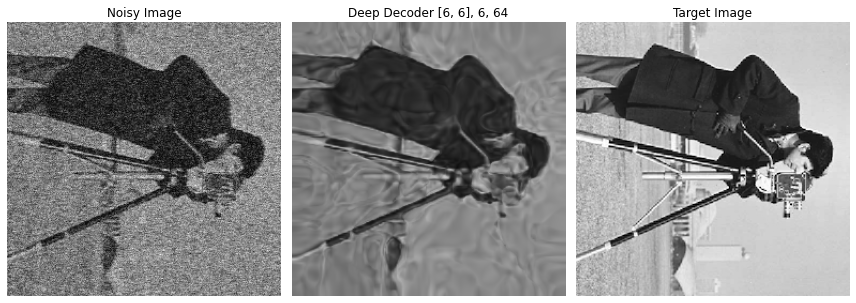

In [4]:
model_image = fitter.get_best_image()
show_images(noisy_image, model_image, target_image, fit_model_configuration.result_path, str(model))

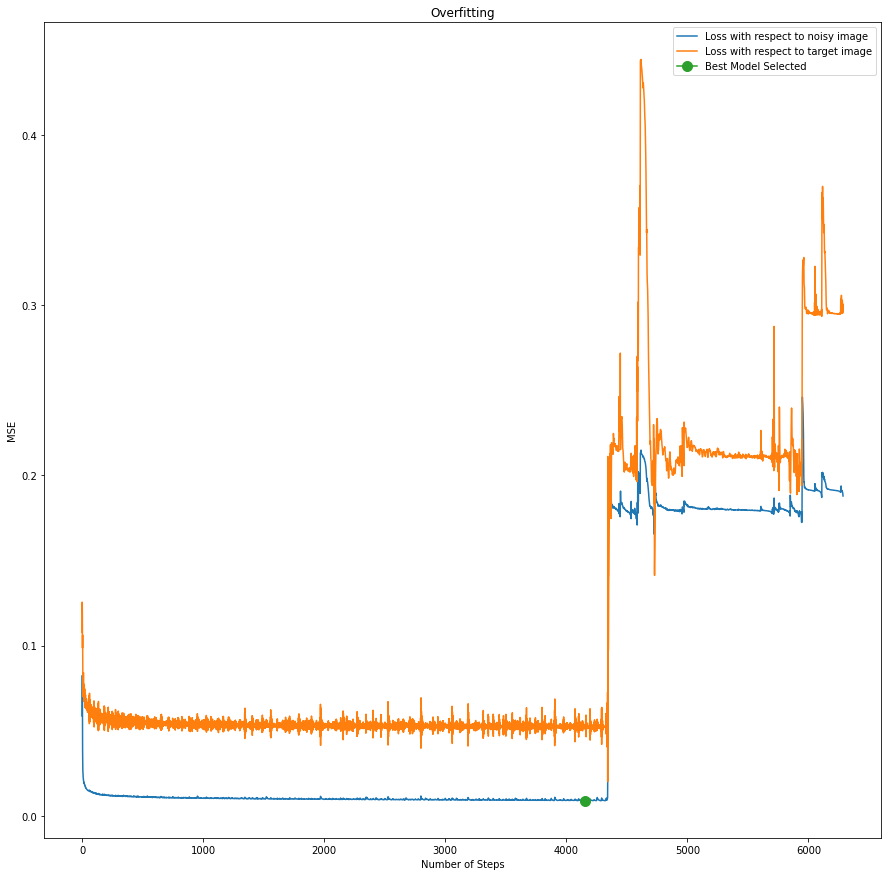

In [5]:
fig = plt.figure(figsize = (15,15))
plt.plot(fitter.losses_wrt_noisy, label = "Loss with respect to noisy image")
plt.plot(fitter.losses_wrt_target, label = "Loss with respect to target image")
plt.plot([fitter.best_model_step], [fitter.best_model_loss.cpu().data], marker='o', ms=10.0, label="Best Model Selected")
plt.xlabel('Number of Steps')
plt.ylabel('MSE')
plt.title('Overfitting')
plt.legend()
plt.show()